In [ ]:
import os
HOME = os.getcwd()
print(HOME)

/content


In [ ]:
import torch
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)

!pip install -i https://test.pypi.org/simple/ supervision==0.3.0
!pip install -q transformers
!pip install timm
import supervision
import transformers
import timm

print(
    "; supervision:", supervision.__version__,
    "; transformers:", transformers.__version__,
    "; timm:", timm.__version__,

)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.2 ; cuda:  cu121
Looking in indexes: https://test.pypi.org/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver

In [ ]:
import cv2
import supervision as sv

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!mkdir {HOME}/datasets
%cd {HOME}/datasets
!mkdir train_data

/content/datasets


In [ ]:
!cp -r /content/drive/MyDrive/MVA2023_Challenge/data/mva2023_sod4bird_train /content/datasets/train_data

In [ ]:
!pwd

/content/datasets


In [ ]:
%cd /content/datasets/train_data/mva2023_sod4bird_train

/content/datasets/train_data/mva2023_sod4bird_train


In [ ]:
!mkdir images_unziped

In [ ]:
!ls

annotations  images_unziped  images.zip  LICENSE


In [47]:
!unzip -q images.zip -d/content/datasets/train_data/mva2023_sod4bird_train/images_unziped

unzip:  cannot find or open images.zip, images.zip.zip or images.zip.ZIP.


In [ ]:
%cd {HOME}
!pwd

/content
/content


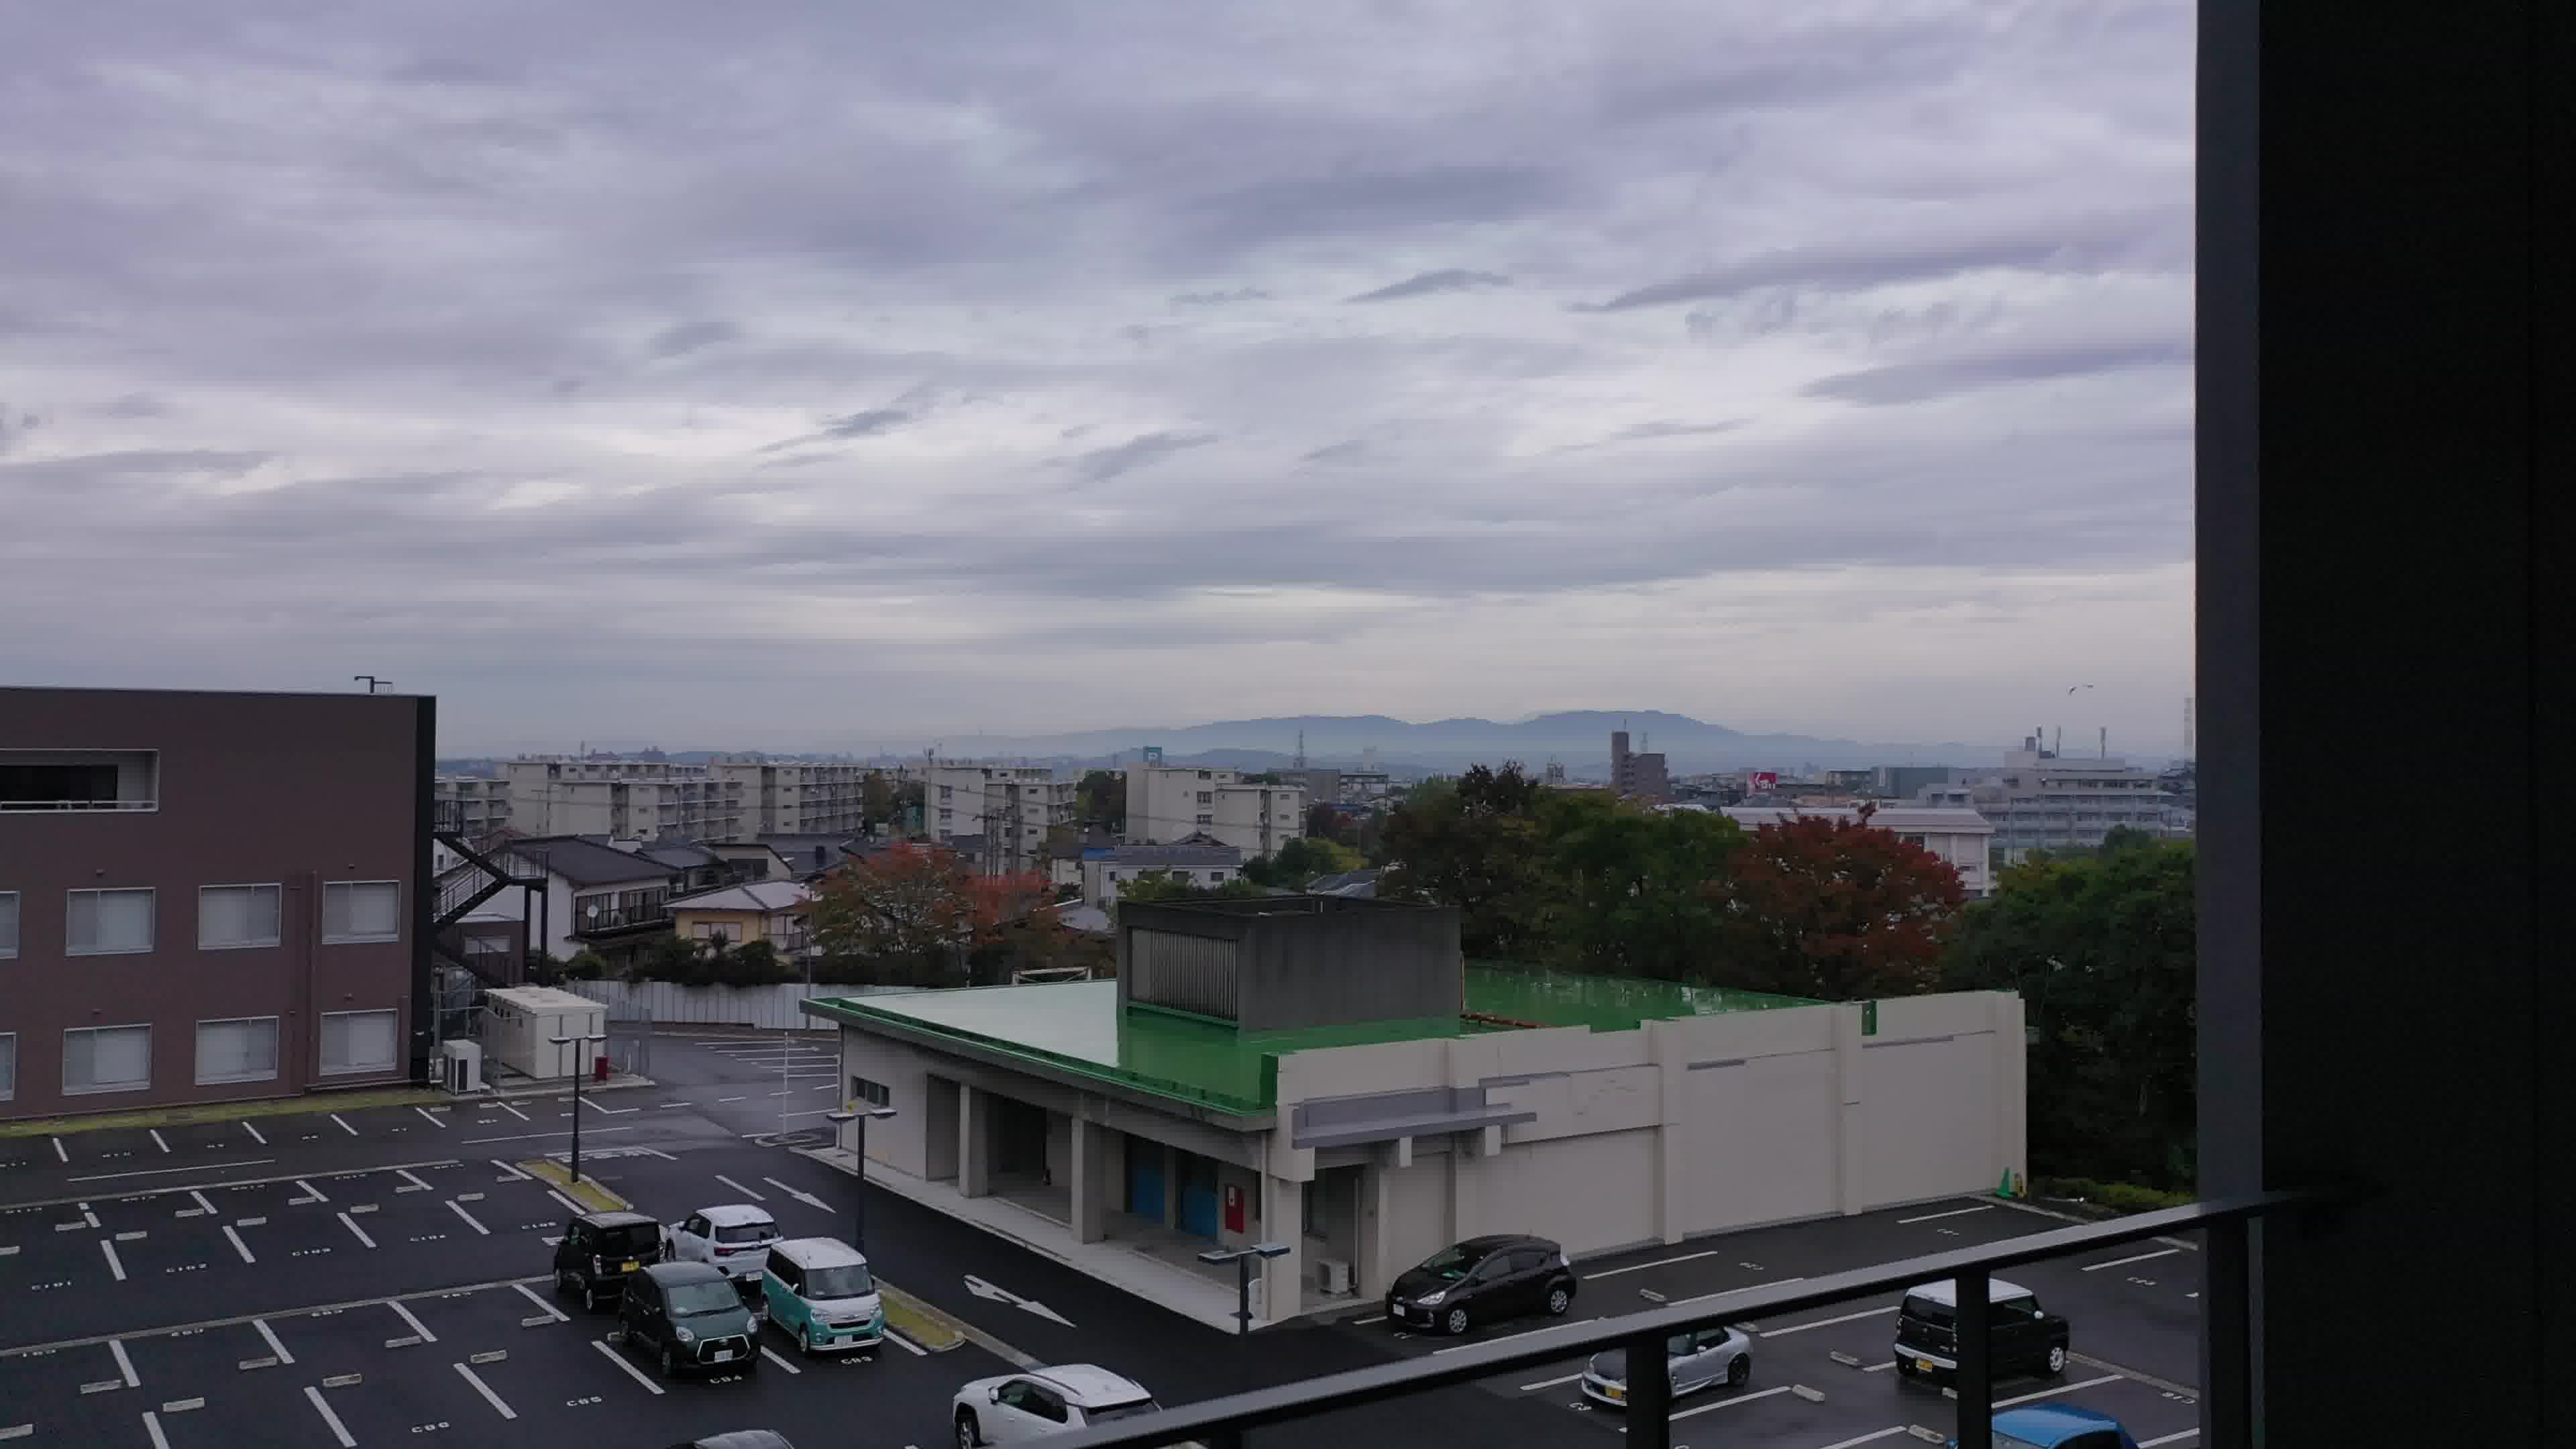

In [ ]:
import matplotlib.pyplot as plt

from google.colab.patches import cv2_imshow
import cv2

# Specify the full path to the image file
img = cv2.imread("/content/datasets/train_data/mva2023_sod4bird_train/images_unziped/images/09759.jpg")
cv2_imshow(img)
# plt.imshow(img)




In [ ]:
dataset_location = "/content/datasets/train_data/mva2023_sod4bird_train"

In [ ]:
import os
import torchvision


# settings
ANNOTATION_FILE_NAME_TRAIN = "split_train_coco.json"
ANNOTATION_FILE_NAME_VAL = "split_val_coco.json"
ANNOTATION_FILE_NAME_MERGED = "merged_train.json"
TRAIN_DIRECTORY = os.path.join(dataset_location, "images_unziped/images")
VAL_DIRECTORY = os.path.join(dataset_location, "images_unziped/images")
MERGE_DIRECTORY = os.path.join(dataset_location, "images_unziped/images")


class CocoDetection(torchvision.datasets.CocoDetection):
    def __init__(
        self,
        image_directory_path: str,
        split_train: bool,
        merged: bool,
        train: bool = True
    ):
        # some hard coding the address due to some issuses
        intermidiate_path_ann = "/content/datasets/train_data/mva2023_sod4bird_train/annotations"
        if split_train:
          annotation_file_path = os.path.join(intermidiate_path_ann, ANNOTATION_FILE_NAME_TRAIN)
        elif merged:
          annotation_file_path = os.path.join(intermidiate_path_ann, ANNOTATION_FILE_NAME_MERGED)
        else:
          annotation_file_path = os.path.join(intermidiate_path_ann, ANNOTATION_FILE_NAME_VAL)

        super(CocoDetection, self).__init__(image_directory_path, annotation_file_path)

    def __getitem__(self, index):
        image, target = super(CocoDetection, self).__getitem__(index)
        return image, target, index



TRAIN_DATASET = CocoDetection(
    image_directory_path=TRAIN_DIRECTORY,
    split_train=True,
    merged=False,
    train=True
    )
VAL_DATASET = CocoDetection(
    image_directory_path=VAL_DIRECTORY,
    split_train=False,
    merged=False,
    train=False
    )
MERGE_DATASET = CocoDetection(
    image_directory_path=MERGE_DIRECTORY,
    split_train=False,
    merged=True,
    train=False)

print("Number of training examples:", len(TRAIN_DATASET))
print("Number of validation examples:", len(VAL_DATASET))
print("Number of merged examples:", len(MERGE_DATASET))
print("sum should be 9759 :", len(TRAIN_DATASET)+len(VAL_DATASET))

loading annotations into memory...
Done (t=0.52s)
creating index...
index created!
loading annotations into memory...
Done (t=0.27s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Number of training examples: 8880
Number of validation examples: 879
Number of merged examples: 9759
sum should be 9759 : 9759


In [ ]:
from transformers import DetrForObjectDetection, DetrImageProcessor


# settings
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
CHECKPOINT = 'facebook/detr-resnet-50'
CONFIDENCE_TRESHOLD = 0.5
IOU_TRESHOLD = 0.8

image_processor = DetrImageProcessor.from_pretrained(CHECKPOINT)
model = DetrForObjectDetection.from_pretrained(CHECKPOINT)
model.to(DEVICE)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/290 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.59k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/detr-resnet-50 were not used when initializing DetrForObjectDetection: ['model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      

Image #1783
1
image-path:  /content/datasets/train_data/mva2023_sod4bird_train/images_unziped/images/01783.jpg
Annotations: [{'area': 540, 'bbox': [1025, 872, 27, 20], 'category_id': 0, 'id': 5129, 'image_id': 1783, 'iscrowd': 0, 'segmentation': [[1025, 872, 1025, 892, 1052, 892, 1052, 872]]}]
Image shape: (2160, 3840, 3)
Detections: Detections(xyxy=array([[1025,  872, 1052,  892]]), class_id=array([0]), confidence=None, tracker_id=None)
Labels: ['bird']


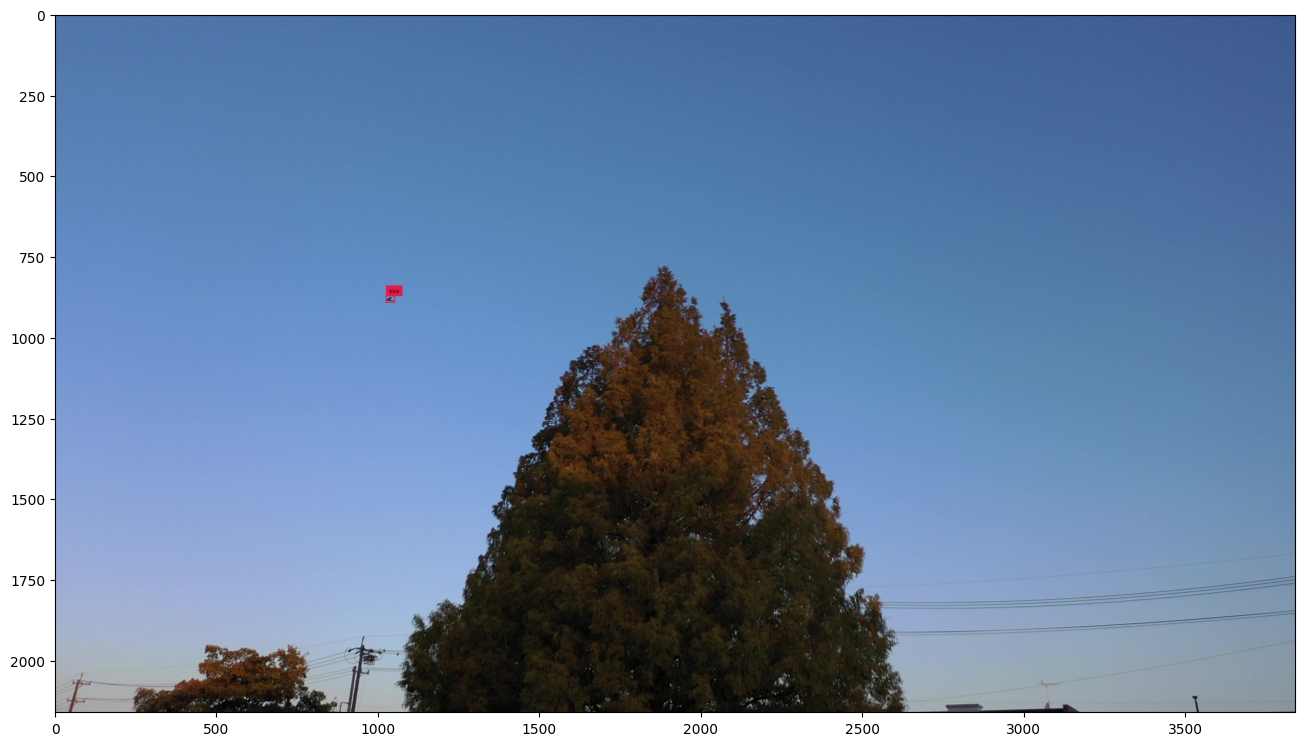

True

In [30]:
import random
import cv2
import numpy as np


# select random image
image_ids = TRAIN_DATASET.coco.getImgIds()
image_id = random.choice(image_ids)
print('Image #{}'.format(image_id))

# load image and annotatons
image = TRAIN_DATASET.coco.loadImgs(image_id)[0]
annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
print(len(annotations))
if len(annotations)>0: # its is very important cause iin some imagese there are not annotation which mean 0 box
  image_path = os.path.join(TRAIN_DATASET.root, image['file_name'])

  print("image-path: ",image_path)
  image = cv2.imread(image_path)
  print("Annotations:", annotations)

  # annotate
  detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)

  # we will use id2label function for training
  categories = TRAIN_DATASET.coco.cats
  id2label = {k: v['name'] for k,v in categories.items()}

  labels = [
      f"{id2label[class_id]}"
      for _, _, class_id, _
      in detections
  ]
  print("Image shape:", image.shape)
  print("Detections:", detections)
  print("Labels:", labels)


  box_annotator = sv.BoxAnnotator()
  frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)


  %matplotlib inline
  sv.show_frame_in_notebook(image, (16, 16))

  # Save the annotated image
annotated_image_path = "/content/assets/annotated_image.jpg"
cv2.imwrite(annotated_image_path, frame)

In [ ]:
print(TRAIN_DATASET.root)

/content/datasets/train_data/mva2023_sod4bird_train/images_unziped/images


In [ ]:
from torch.utils.data import DataLoader

def collate_fn(batch):
    # Collect images, targets, and indices from the batch
    images = [item[0] for item in batch]
    targets = [item[1] for item in batch]
    indices = [item[2] for item in batch]

    # You may need to perform additional processing here depending on your requirements

    return {
        'images': images,
        'targets': targets,
        'indices': indices
    }

# Create DataLoader instances for training and validation



TRAIN_DATALOADER = DataLoader(dataset=TRAIN_DATASET, collate_fn=collate_fn, batch_size=4, shuffle=True)
VAL_DATALOADER = DataLoader(dataset=VAL_DATASET, collate_fn=collate_fn, batch_size=4)


In [ ]:
for batch_data in VAL_DATALOADER:
    print(batch_data)
    break  # Print only the first batch for inspection


{'images': [<PIL.Image.Image image mode=RGB size=3840x2160 at 0x7E0C7BE71C90>, <PIL.Image.Image image mode=RGB size=3840x2160 at 0x7E0C7BE71B40>, <PIL.Image.Image image mode=RGB size=3840x2160 at 0x7E0C7BE71EA0>, <PIL.Image.Image image mode=RGB size=3840x2160 at 0x7E0C7BE72D70>], 'targets': [[{'area': 550, 'bbox': [1018, 1247, 22, 25], 'category_id': 0, 'id': 12, 'image_id': 11, 'iscrowd': 0, 'segmentation': [[1018, 1247, 1018, 1272, 1040, 1272, 1040, 1247]]}, {'area': 870, 'bbox': [1283, 1262, 29, 30], 'category_id': 0, 'id': 13, 'image_id': 11, 'iscrowd': 0, 'segmentation': [[1283, 1262, 1283, 1292, 1312, 1292, 1312, 1262]]}, {'area': 725, 'bbox': [2129, 1238, 29, 25], 'category_id': 0, 'id': 14, 'image_id': 11, 'iscrowd': 0, 'segmentation': [[2129, 1238, 2129, 1263, 2158, 1263, 2158, 1238]]}, {'area': 475, 'bbox': [1929, 1216, 25, 19], 'category_id': 0, 'id': 15, 'image_id': 11, 'iscrowd': 0, 'segmentation': [[1929, 1216, 1929, 1235, 1954, 1235, 1954, 1216]]}, {'area': 460, 'bbox': 

In [ ]:
for batch_data in TRAIN_DATALOADER:
    print(batch_data)
    break  # Print only the first batch for inspection

{'images': [<PIL.Image.Image image mode=RGB size=3840x2160 at 0x7E0C7BE73B50>, <PIL.Image.Image image mode=RGB size=3840x2160 at 0x7E0C7BE70AC0>, <PIL.Image.Image image mode=RGB size=3840x2160 at 0x7E0C7BE70A00>, <PIL.Image.Image image mode=RGB size=3840x2160 at 0x7E0C7BE70C70>], 'targets': [[{'area': 247, 'bbox': [2207, 617, 19, 13], 'category_id': 0, 'id': 25553, 'image_id': 8634, 'iscrowd': 0, 'segmentation': [[2207, 617, 2207, 630, 2226, 630, 2226, 617]]}, {'area': 270, 'bbox': [2264, 1159, 18, 15], 'category_id': 0, 'id': 25554, 'image_id': 8634, 'iscrowd': 0, 'segmentation': [[2264, 1159, 2264, 1174, 2282, 1174, 2282, 1159]]}, {'area': 104, 'bbox': [1245, 1682, 13, 8], 'category_id': 0, 'id': 25555, 'image_id': 8634, 'iscrowd': 0, 'segmentation': [[1245, 1682, 1245, 1690, 1258, 1690, 1258, 1682]]}, {'area': 182, 'bbox': [2200, 1428, 14, 13], 'category_id': 0, 'id': 25556, 'image_id': 8634, 'iscrowd': 0, 'segmentation': [[2200, 1428, 2200, 1441, 2214, 1441, 2214, 1428]]}, {'area':

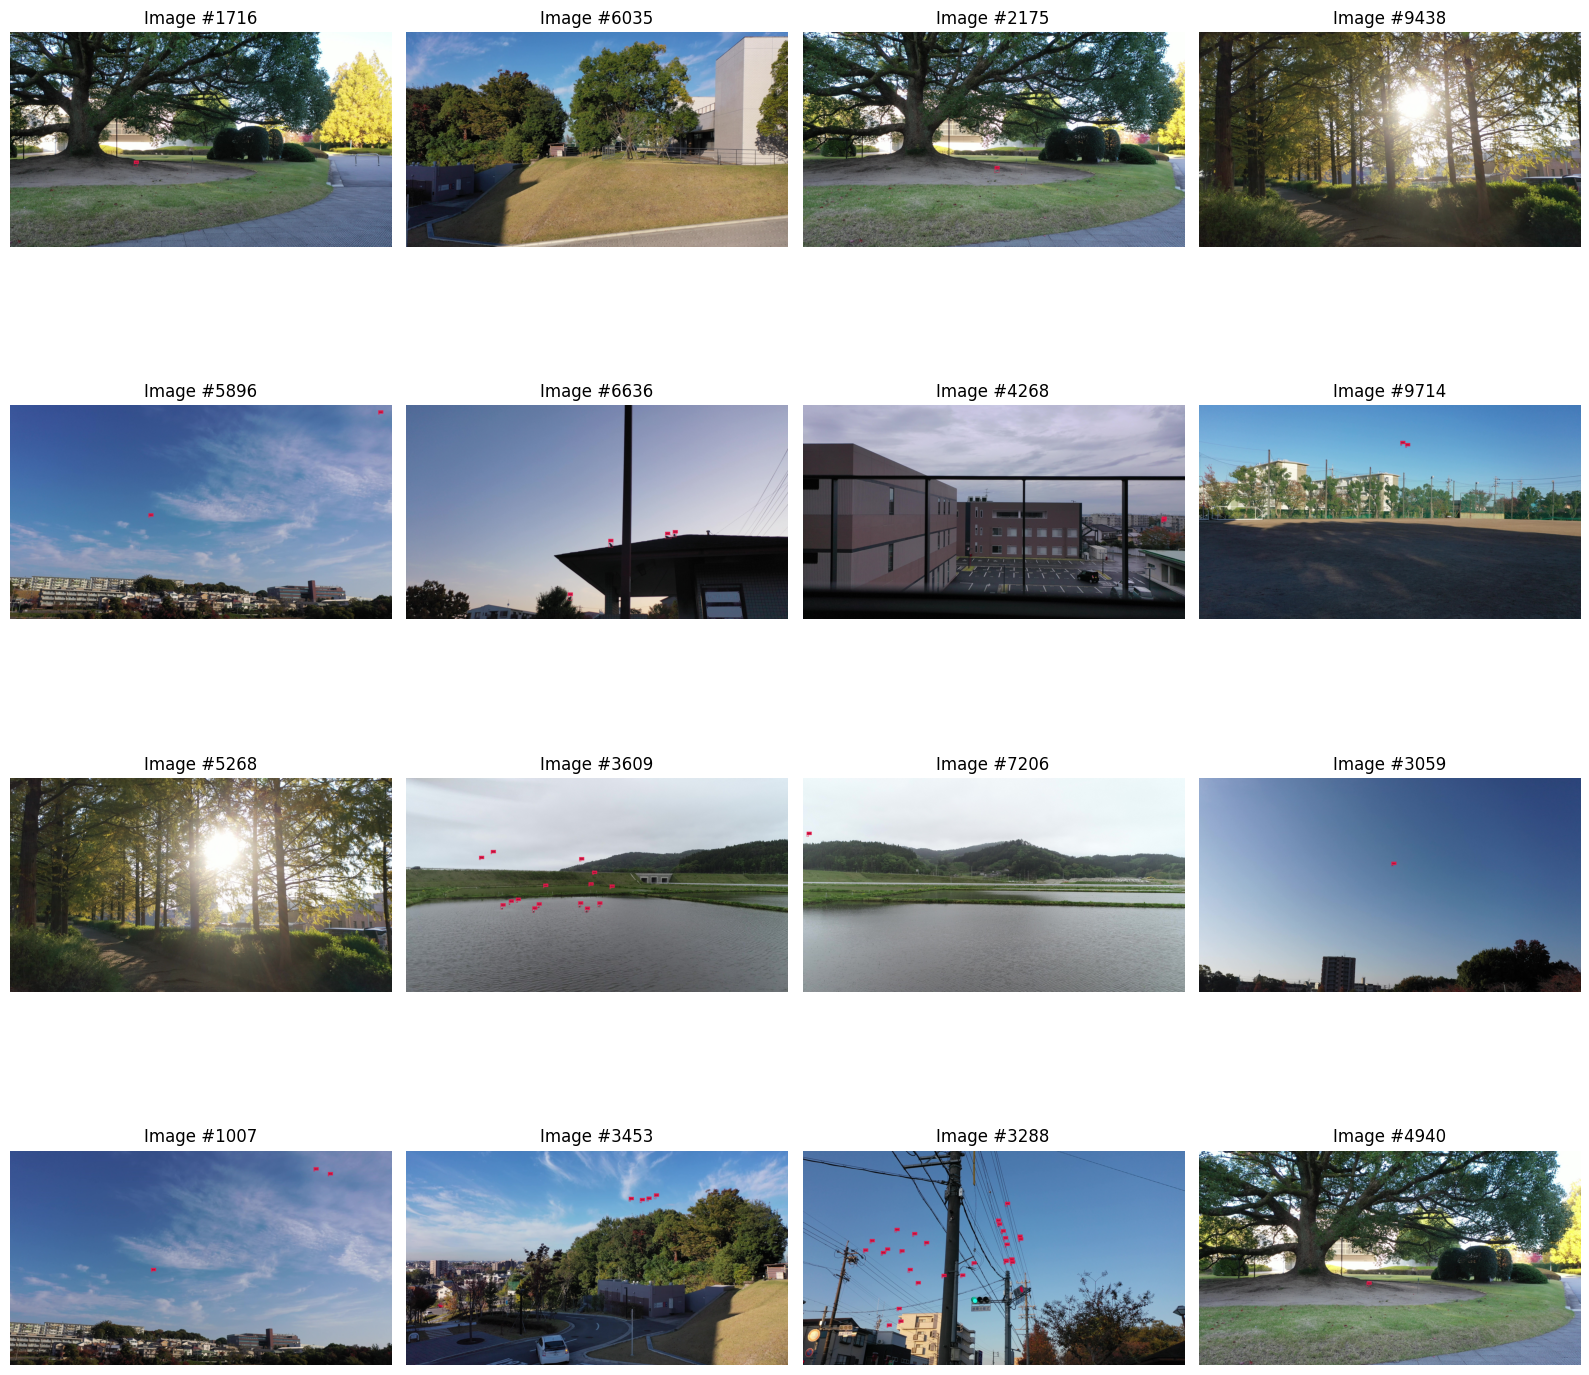

In [33]:
import matplotlib.pyplot as plt

# Select 16 random image IDs
image_ids = random.sample(TRAIN_DATASET.coco.getImgIds(), 16)

# Create a 4x4 grid of subplots
fig, axes = plt.subplots(4, 4, figsize=(16, 16))

# Iterate through each subplot and plot an image
for i in range(4):
    for j in range(4):
        # Get a random image ID
        image_id = image_ids[i * 4 + j]
        # Load the image and annotations
        image_info = TRAIN_DATASET.coco.loadImgs(image_id)[0]
        annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
        image_path = os.path.join(TRAIN_DATASET.root, image_info['file_name'])
        image = cv2.imread(image_path)

        if len(annotations) > 0:
            # Annotate the image
            detections = sv.Detections.from_coco_annotations(coco_annotation=annotations)
            categories = TRAIN_DATASET.coco.cats
            id2label = {k: v['name'] for k, v in categories.items()}
            labels = [f"{id2label[class_id]}" for _, _, class_id, _ in detections]
            box_annotator = sv.BoxAnnotator()
            frame = box_annotator.annotate(scene=image, detections=detections, labels=labels)
            # Plot the image with annotations
            axes[i, j].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        else:
            # Plot the image without annotations
            axes[i, j].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

        axes[i, j].set_title(f'Image #{image_id}')
        axes[i, j].axis('off')

# Adjust layout
plt.tight_layout()

plt.savefig("/content/assets/sample_image_TRAIN_dataset.jpg")

# Show the plot
plt.show()


In [32]:
plt.savefig("/content/assets/sample_image_TRAIN_dataset.jpg")

<Figure size 640x480 with 0 Axes>

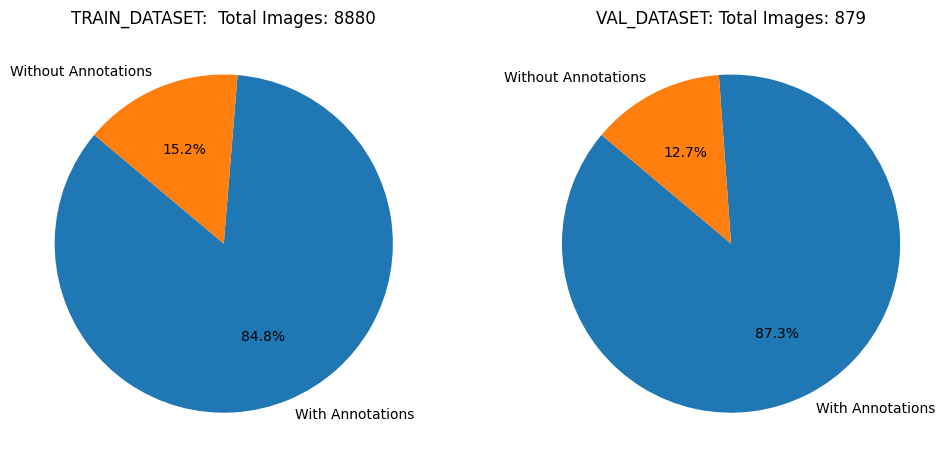

In [46]:
import matplotlib.pyplot as plt

# Calculate the total number of images in TRAIN_DATASET and VAL_DATASET
total_train_images = len(TRAIN_DATASET)
total_val_images = len(VAL_DATASET)

train_zero_annotation_count = 0
val_zero_annotation_count = 0

# Iterate through TRAIN_DATASET and count images with zero annotations
for image_id in TRAIN_DATASET.coco.imgs.keys():
    annotations = TRAIN_DATASET.coco.imgToAnns[image_id]
    if len(annotations) == 0:
        train_zero_annotation_count += 1

# Iterate through VAL_DATASET and count images with zero annotations
for image_id in VAL_DATASET.coco.imgs.keys():
    annotations = VAL_DATASET.coco.imgToAnns[image_id]
    if len(annotations) == 0:
        val_zero_annotation_count += 1

# Calculate the number of images with zero annotations in TRAIN_DATASET and VAL_DATASET
train_images_with_annotations = total_train_images - train_zero_annotation_count
val_images_with_annotations = total_val_images - val_zero_annotation_count

# Data for TRAIN_DATASET pie chart
train_data = [train_images_with_annotations, train_zero_annotation_count]
train_labels = ['With Annotations', 'Without Annotations']

# Data for VAL_DATASET pie chart
val_data = [val_images_with_annotations, val_zero_annotation_count]
val_labels = ['With Annotations', 'Without Annotations']

# Plotting the pie chart for TRAIN_DATASET
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.pie(train_data, labels=train_labels, autopct='%1.1f%%', startangle=140)
plt.title('TRAIN_DATASET:  Total Images: {}'.format(total_train_images))

# Plotting the pie chart for VAL_DATASET
plt.subplot(1, 2, 2)
plt.pie(val_data, labels=val_labels, autopct='%1.1f%%', startangle=140)
plt.title('VAL_DATASET: Total Images: {}'.format(total_val_images))
plt.savefig("/content/assets/data_info.jpg")
plt.show()
